From BTK1_IB/md/13/unlinked/US/US_linkdist/analysis 

Fall 2025

In [1]:
import os
from pathlib import Path
from dataclasses import dataclass
import subprocess as sp

import numpy as np
import matplotlib.pyplot as plt

In [2]:
PROJECT_ROOT = Path("..").resolve()
ANALYSIS_DIR = Path(".").resolve()

US_PATTERN = "US_*"      # expects dirs like US_3.2, US_3.6, ...
DIST_PREFIX = "dist"     # dist_<center>.<run>.dat

# wham params
WHAM_EXE = Path("~/utilities/wham/wham/wham/wham").expanduser()
CV_MIN = 3
CV_MAX = 7.8
NBINS = 50
TEMPERATURE = 310.0       # K
WHAM_TOL = 1e-5

# Umbrella spring constant
# Note that amber uses k(x)^2 while wham uses 0.5k(x)^2, so to convert multiply the amber force constant by 2
k_AMBER = 10
k_WHAM = k_AMBER * 2

HEADER_PREFIXES = ("#", "@")

In [3]:
@dataclass
class Window:
    center_str: str     # "3.2"
    center: float       # 3.2
    path: Path          # ../US_3.2
    run_indices: list   # [0, 1, 2]
    
def discover_windows(project_root: Path) -> list:
    """
    Enumerate US_* directories and associated dist_<center>.<run>.dat files.
    """
    windows = []
    for d in sorted(project_root.glob(US_PATTERN)):
        if not d.is_dir():
            continue
        # US_3.2 → "3.2"
        center_str = d.name.split("_", 1)[1]
        center = float(center_str)

        dist_glob = f"{DIST_PREFIX}_{center_str}.*.dat"
        dist_files = sorted(d.glob(dist_glob))
        if not dist_files:
            continue

        run_indices = sorted(
            {int(f.stem.split(".")[-1]) for f in dist_files if f.stem.split(".")[-1].isdigit()}
        )
        windows.append(Window(center_str=center_str,
                              center=center,
                              path=d,
                              run_indices=run_indices))
        
    windows.sort(key=lambda w: w.center)
    return windows

def combine_dist_files(window: Window,
                       n_runs: int,
                       out_dir: Path,
                       stride: int = 1) -> Path:
    """ 
    Concatenate first n_runs dist_<center>.<run>.dat for a window into one file. Skips repeated header lines (lines starting with HEADER_PREFIXES).
    """
    out_dir.mkdir(parents=True, exist_ok=True)
    out_path = window.path / f"{DIST_PREFIX}_{window.center_str}.n{n_runs}.dat"

    selected = window.run_indices[:n_runs]
    in_paths = [
        window.path / f"{DIST_PREFIX}_{window.center_str}.{idx}.dat"
        for idx in selected
    ]

    header_written = False
    with out_path.open("w") as fout:
        for p in in_paths:
            with p.open() as fin:
                for i, line in enumerate(fin):
                    if line.lstrip().startswith(HEADER_PREFIXES):
                        if not header_written:
                            fout.write(line)
                        continue
                    if i % stride == 0:
                        fout.write(line)
            header_written = True

    return out_path


def write_meta_file(windows: list,
                    n_runs: int,
                    analysis_dir: Path,
                    k_spring: float) -> Path:
    """
    Build WHAM metadata file of form:
    <time_series_file>   <center>   <force_constant>
    """
    meta_path = analysis_dir / f"meta.n{n_runs}.dat"
    with meta_path.open("w") as f:
        f.write("# file center k\n")
        for w in windows:
            series_path = w.path / f"{DIST_PREFIX}_{w.center_str}.n{n_runs}.dat"
            f.write(f"{series_path} {w.center:.6f} {k_spring:.6f}\n")
    return meta_path

def run_wham(meta_path: Path,
             n_runs: int,
             analysis_dir: Path,
             wham_exe: str = WHAM_EXE,
             cv_min: float = CV_MIN,
             cv_max: float = CV_MAX,
             nbins: int = NBINS,
             temperature: float = TEMPERATURE,
             tol: float = WHAM_TOL,
             numpad=0) -> Path:
    """
    Call Grossfield WHAM.
    """
    pmf_path = analysis_dir / f"pmf.n{n_runs}.dat"

    cmd = [
        wham_exe,
        f"{cv_min:.6f}",
        f"{cv_max:.6f}",
        str(nbins),
        f"{tol:.1e}",
        f"{temperature:.6f}",
        str(numpad),
        str(meta_path),
        str(pmf_path)
    ]

    sp.run(cmd, check=True)
    return pmf_path


def load_pmf(path: Path) -> tuple[np.ndarray, np.ndarray]:
    """
    Load WHAM PMF
    """
    arr = np.loadtxt(path)
    x = arr[:, 0]
    F = arr[:, 1]
    return x, F



In [4]:
def build_all_convergence_stages():
    """
    For each n_runs, build combined trajectories, meta, run WHAM, and collect PMFs.
    """
    windows = discover_windows(PROJECT_ROOT)
    if not windows:
        raise RuntimeError("No US_* windows discovered.")

    # require same number of runs across windows; truncate to common minimum
    n_common = min(len(w.run_indices) for w in windows)
    if n_common < 1:
        raise RuntimeError("No runs found in windows.")

    pmfs = {}  # n_runs: (x, F)

    for n_runs in range(1, n_common + 1):
        # concatenate time series
        for w in windows:
            combine_dist_files(w, n_runs, ANALYSIS_DIR)

        # meta and WHAM
        meta_path = write_meta_file(windows, n_runs, ANALYSIS_DIR, k_WHAM)
        pmf_path = run_wham(meta_path, n_runs, ANALYSIS_DIR)
        pmfs[n_runs] = load_pmf(pmf_path)

    return pmfs


def plot_pmfs(pmfs: dict):
    """
    Plot PMF for each cumulative n_runs. Overlays multiple curves.
    """
    plt.figure()
    for n_runs, (x, F) in sorted(pmfs.items()):
        plt.plot(x, F, label=f"{n_runs*100} ns")

    plt.xlabel("CV (Å)")
    plt.ylabel("PMF")
    plt.xlim(CV_MIN, CV_MAX)
    plt.ylim(0, plt.ylim()[1])
    plt.legend()
    plt.tight_layout()

In [5]:
pmfs_dict = build_all_convergence_stages()

# /home/kyleghaby/utilities/wham/wham/wham/wham 3.000000 7.800000 50 1.0e-05 310.000000 0 /beagle3/roux/kyleghaby/kininhibs/main/BTK1_IB/md/13/unlinked/US/US_linkdist/analysis/meta.n1.dat /beagle3/roux/kyleghaby/kininhibs/main/BTK1_IB/md/13/unlinked/US/US_linkdist/analysis/pmf.n1.dat
#Number of windows = 12
#Iteration 10:  0.034444
#Iteration 20:  0.015504
#Iteration 30:  0.010102
#Iteration 40:  0.007219
#Iteration 50:  0.005423
#Iteration 60:  0.004245
#Iteration 70:  0.003435
#Iteration 80:  0.002851
#Iteration 90:  0.002408
#Iteration 100:  0.002059
3.048000	6.741227	0.000487
3.144000	4.974988	0.008625
3.240000	3.742383	0.064059
3.336000	2.880591	0.260282
3.432000	2.270555	0.702164
3.528000	1.820421	1.460365
3.624000	1.502721	2.448605
3.720000	1.267577	3.589631
3.816000	1.115257	4.599017
3.912000	0.998463	5.561362
4.008000	0.874359	6.805519
4.104000	0.767430	8.098548
4.200000	0.695745	9.100249
4.296000	0.691170	9.168227
4.392000	0.729669	8.611635
4.488000	0.772242	8.035398
4.584000

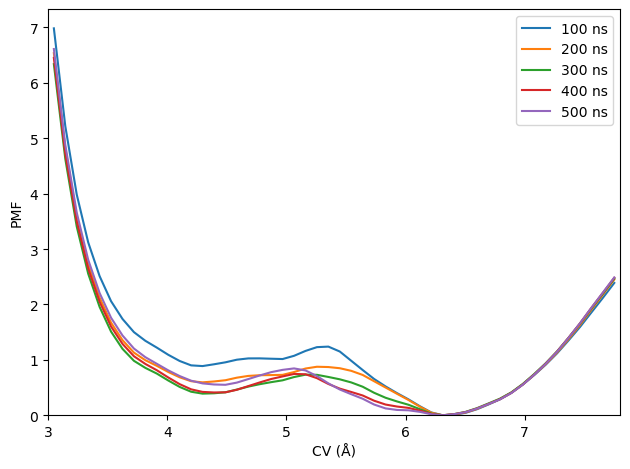

In [6]:
plot_pmfs(pmfs_dict)
plt.show()

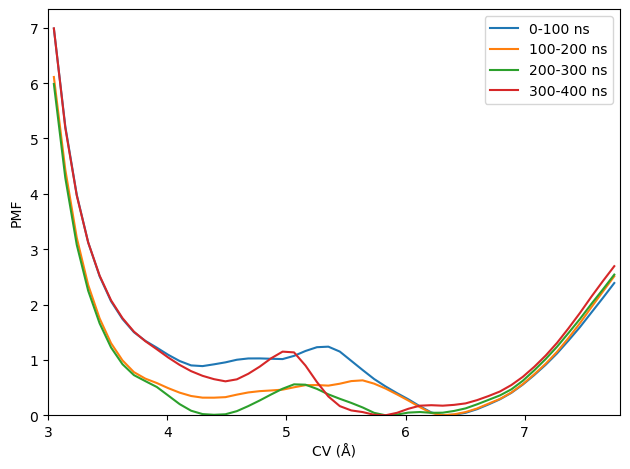

In [10]:
plot_pmfs(pmfs_dict)
plt.show()